# Uber Marketplace City X Challenge

## Goal
Choose one:
<ol>
<li>Investigate whether Drivers are adequately notified about the city's demand in certain geographic areas at certain times. Present a strategy to address the challenge.
</ol>

## Deliverables

<ol>
<li>An educated, data-driven view on the potential issue
<li>A A/B test design to evalue a hypothesis or test a solution
<li>Recommended next steps and other factors to consider
</ol>

## Evaluation criteria

<ul>
<li>data cleaning, aggregation, and analysis
<li>identification of key patterns and trends
<li>strong and relevant experiment design
<li>recommendations including actionable next steps
<li>acknowledgement of other factors or considerations
</ul>

# TODO List

<ul>
<li>Calculate by-hour statistics for each of the four geos to add to city table
<li>Look at requests vs trips vs. hour by geo
<li>Look into the gap between requests and trips by trip status: rider_canceled vs. unfulfilled
<li>Look into why riders canceled: did they eventually successfully book a trip right after canceling, or is there a correlation between wait time and cancelation rate?
<li>Group trips by driver_id and estimate the trip time by time between pickup and next request time, for times when demand is high (completed trips < trips requested)
</ul>

## Odd Stuff

<ul>
<li>Trip ID 94a1-82d8 is not unique: there four trips with this trip_id. Since four trips will not affect our conclusions these rows are simply dropped 
<li>There is a rider with $139k in payments and over 16k trips. Who could afford to do that (and have enough time) in a lifetime?
<li>similar situation with the driver info: one driver with many more trips than any other
<li>missing est. time to arrival in some 2501 rider trips (about 10% of the total number of trips)
</ul>

In [1]:
import pandas as pd
import math
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(f"This notebook was prepared with:\n  pandas version 0.23.4. Your version: {pd.__version__}")

This notebook was prepared with:
  pandas version 0.23.4. Your version: 0.23.4


## City Demand and Driver Positioning

The city GM believes there are disproportionate levels of surge pricing and higher ETAs in CC - sometimes 1-2 minutes higher than the city average - during rush hour. Also notes trip growth has been inconsistent in April and May. Question: could "fixing" driver placement during CC rush hour help improve rider growth?

Some possible indicators of non-optimal driver positioning could include:
<ul>
<li>surge multiplier disparity: key indicator of poor driver positioning. If surge is 1 or low in one geo and very high in another, drivers could be more optimally positioned. 
<li>fraction of rider cancellations: how does cancellation rate depend on wait time? What is the impact of cancelation on rider retention?
<li>high estimated_times_to_arrival: could indicate poor positioning, but also could be caused by traffic congestion, or lack of driver supply. We can get an idea of the effect of traffic congestion by looking at the number of trips completed per supply hour vs. time of day. 
<li>fraction of trip requests unfulfilled: indicates lack of overall supply. Here, again, looking for disparities between regions would be more indicative of poor positioning, but statistics for unfulfilled trips could be limited
</ul>

## Exploring the city info table

In [3]:
city = pd.read_html("city_metrics.html", header=1, index_col='timestamp')[0]

In [4]:
city['datetime'] = pd.to_datetime(city.index)
city.set_index('datetime', drop=True, inplace=True)
city = city.rename(columns={ 'mean_surge_multipler' : 'mean_surge_multiplier' })
city['date'] = city.index.date
city['dow'] = city.index.day_name()
city['woy'] = city.index.weekofyear
city['hour'] = city.index.hour

In [5]:
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday' ]
rush_hours = [ 7, 8, 17, 18 ] 

In [319]:
city.groupby('woy').agg({'requests':['sum', np.sum( lambda x: 1/np.sqrt(x))]})

Exception: Must produce aggregated value

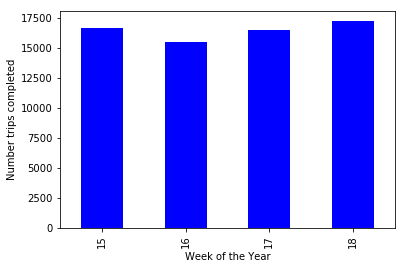

In [83]:
pl = city.groupby('woy').agg('sum').plot(y='trips', kind='bar', color='blue', legend=False)
plt.xlabel("Week of the Year")
plt.ylabel("Number trips completed")

In [84]:
# Trips per supply hour: average number of driver trips/hour 
city['trips_per_supply_hour'] = city['trips']/city['supply_hours']

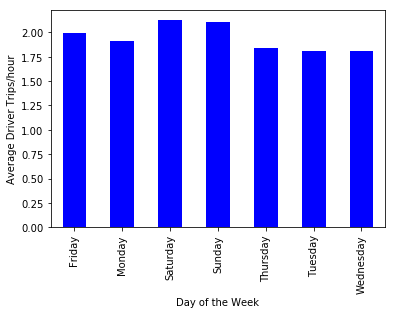

In [85]:
city.groupby('dow').agg('mean').plot(y='trips_per_supply_hour', kind='bar', color='blue', legend=False)
plt.ylabel('Average Driver Trips/hour')
plt.xlabel('Day of the Week')

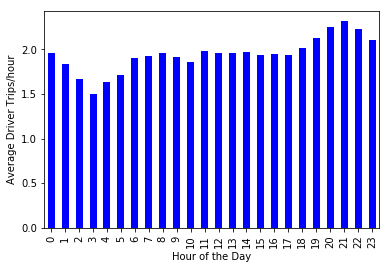

In [86]:
city.groupby('hour').agg('mean').plot(y='trips_per_supply_hour', kind='bar', color='blue', legend=False)
plt.ylabel('Average Driver Trips/hour')
plt.xlabel('Hour of the Day')

In [87]:
# Trip Supply Deficit: Difference between trips completed and requests
city['rider_cancelations_frac'] = (city['requests'] - city['trips'])/city['requests'] 
city['rider_cancelations'] = city['requests'] - city['trips']

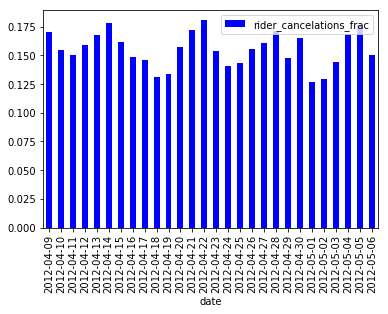

In [88]:
city.groupby('date').agg('mean').plot(y='rider_cancelations_frac', kind='bar', color='blue')

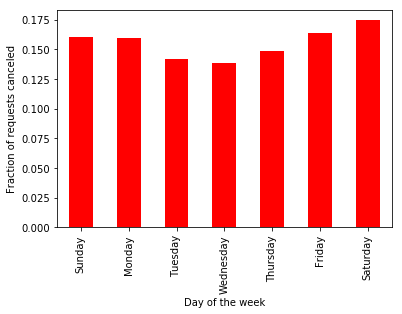

In [89]:
trip_deficit_frac_by_day = city.groupby('dow').agg('mean').loc[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], :].plot(y='rider_cancelations_frac', kind='bar', color='red',  legend=False)
plt.ylabel("Fraction of requests canceled")
plt.xlabel("Day of the week")

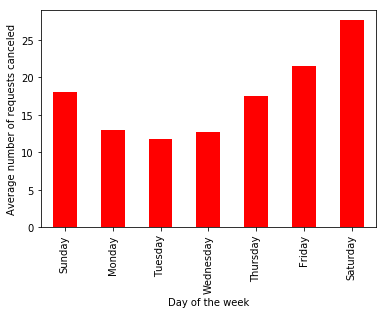

In [90]:
rider_cancelations_number_by_day = city.groupby('dow').agg('mean').loc[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], :].plot(y='rider_cancelations', kind='bar', color='red',  legend=False)
plt.ylabel("Average number of requests canceled")
plt.xlabel("Day of the week")

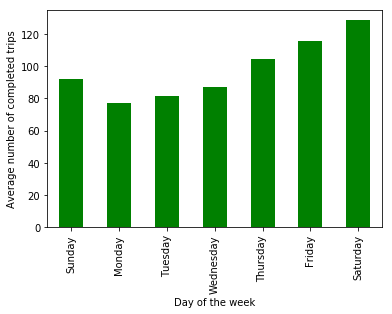

In [92]:
completed_trips_by_day = city.groupby('dow').agg('mean').loc[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], :].plot(y='trips', kind='bar', color='green',  legend=False)
plt.ylabel("Average number of completed trips")
plt.xlabel("Day of the week")

In [98]:
city_weekdays = city.loc[ city['dow'].isin( weekdays ) ]
weekday_by_hour = city_weekdays.groupby('hour').mean()

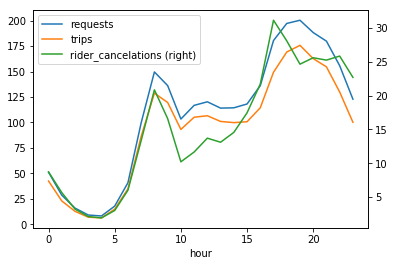

In [99]:
weekday_by_hour.plot(y=['requests', 'trips', 'rider_cancelations'], secondary_y=['rider_cancelations'])

Morning weekday rush hour: 8-9

Evening weekday rush hour: 17-20

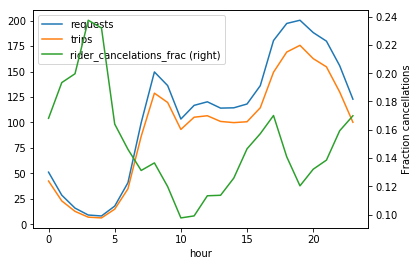

In [112]:
ax = weekday_by_hour.plot(y=['requests', 'trips', 'rider_cancelations_frac'], secondary_y=['rider_cancelations_frac'])
plt.ylabel('Fraction cancellations')

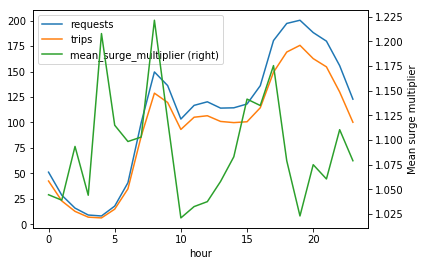

In [114]:
weekday_by_hour.plot(y=['requests', 'trips', 'mean_surge_multiplier'], secondary_y=['mean_surge_multiplier'])
plt.ylabel("Mean surge multiplier")

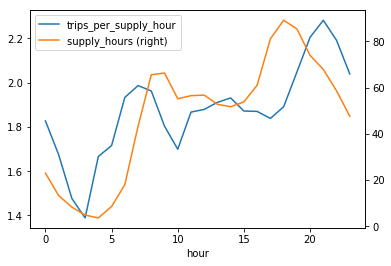

In [102]:
weekday_by_hour.plot(y=['trips_per_supply_hour', 'supply_hours'], secondary_y=['supply_hours'])

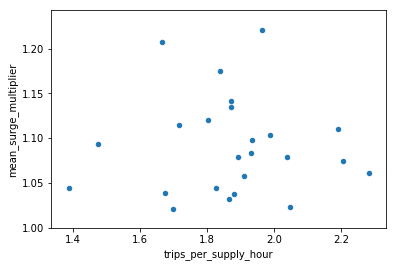

In [103]:
weekday_by_hour.plot( y='mean_surge_multiplier', x='trips_per_supply_hour', kind='scatter')

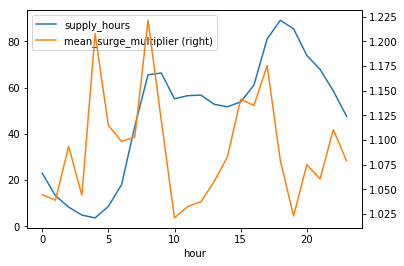

In [104]:
weekday_by_hour.plot(y=['supply_hours', 'mean_surge_multiplier'], secondary_y=['mean_surge_multiplier'])

## Trips Data import, cleaning, and aggregation

In [105]:
d_trips = pd.read_html("driver_trips.html", header=1, index_col='trip_id')[0] 

In [106]:
r_trips = pd.read_html("rider_trips.html", header=1, index_col='trip_id')[0]

In [115]:
drivers = pd.read_html("driver_data.html", header=1, index_col='driver_id')[0]
riders = pd.read_html("rider_data.html", header=1, index_col='rider_id')[0]

In [117]:
d_trips.drop(columns="1", inplace=True)
r_trips.drop(columns="1", inplace=True)
drivers.drop(columns="1", inplace=True)
riders.drop(columns="1", inplace=True)

KeyError: "['1'] not found in axis"

In [118]:
# Join the driver trips and rider trips tables on trip_id
trips = r_trips.join(d_trips, how='left', lsuffix='_d', rsuffix='_r')

In [119]:
dup_columns = [ c_name.replace("_r", "") for c_name in trips.columns if "_r" in c_name ]
for c in dup_columns:
    r_col = c + "_r"
    d_col = c + "_d"
    trips[c] = trips[r_col].where( ~trips[r_col].isnull(), trips[d_col] )
    trips = trips.drop(columns=[r_col, d_col])

In [120]:
# This trip_id is not unique!
trips = trips.drop('94a1-82d8', axis=0)

In [121]:
trips['request_time'] = pd.to_datetime(trips['request_time'])
trips['dow'] = trips.request_time.dt.day_name()
trips['date'] = trips.request_time.dt.date
trips['hour'] = trips.request_time.dt.hour

In [122]:
trips['is_rush_hour'] = ( trips.hour.isin(rush_hours)) & ( trips.dow.isin(weekdays) )
trips['completed'] = trips.trip_status.apply(lambda x : 1 if x == 'completed' else 0)
trips['canceled'] = trips.trip_status.apply(lambda x : 1 if x == 'rider_canceled' else 0)

In [125]:
completed_trips = trips.loc[trips['trip_status']=='complete']

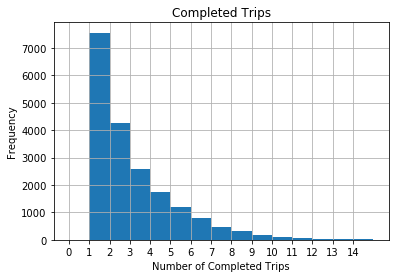

In [286]:
completed_trips.groupby('driver_id').agg({'rider_id':'count'}).sort_values('rider_id', ascending=False).rename(columns={'rider_id':'Completed Trips'}).hist(range=(0, 15), bins=15, )
plt.ylabel('Frequency')
plt.xlabel('Number of Completed Trips')
ax = plt.xticks(np.arange(0, 15, 1))

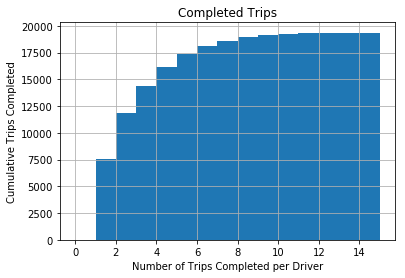

In [293]:
ax = completed_trips.groupby('driver_id').agg({'rider_id':'count'}).sort_values('rider_id', ascending=False).rename(columns={'rider_id':'Completed Trips'}).hist(range=(0, 15), bins=15, cumulative=1)
plt.ylabel("Cumulative Trips Completed")
plt.xlabel("Number of Trips Completed per Driver")

In [123]:
canceled_trips = trips.loc[trips['trip_status']=='rider_canceled']

In [124]:
canceled_trips.groupby('driver_id')['canceled'].count().sort_values(ascending=False).head(10)

driver_id
4e79-a40f    80
4944-de55     7
4e0b-08df     6
4c5a-bdaf     5
4f71-6965     5
432f-c925     5
4b24-2cba     4
4677-5df9     4
4606-155f     4
4706-ed8f     4
Name: canceled, dtype: int64

In [249]:
trips.loc[trips['trip_status']=='completed'].groupby('driver_id').agg({'trip_id':'count'}).rename(columns={'trip_id':"Completed trips"})

/Users/david/anaconda2/envs/PythonData/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


KeyError: 'trip_id'

In [43]:
drivers.loc[drivers.index == '4e79-a40f']

,first_completed_trip,lifetime_rating,lifetime_fares,lifetime_completed_trips
driver_id,,,,
4e79-a40f,10/12/2010,4.99,8.054105e+08,41940330


In [311]:
n_impossible = drivers.loc[drivers.index == '4e79-a40f']['lifetime_completed_trips'].values[0]
n_years = n_impossible/12/24/365.25
print(f"This driver has a lifetime number of completed trips that, assuming just 5 minutes per trip, would take {round(n_years,0)} years to accomplish, driving non-stop.")

This driver has a lifetime number of completed trips that, assuming just 5 minutes per trip, would take 399.0 years to accomplish, driving non-stop.


In [126]:
len(trips.loc[ (trips.driver_id=='4e79-a40f') & (trips.trip_status=='completed') ])

2210

In [138]:
cancels_per_driver = trips.loc[ (trips.trip_status=='rider_canceled')].groupby('driver_id').agg({'rider_id':'count'}).rename(columns={'rider_id':'canceled'})

In [139]:
completed_per_driver = trips.loc[ (trips.trip_status=='completed')].groupby('driver_id').agg({'rider_id':'count'}).rename(columns={ 'rider_id':'completed' })

In [140]:
requests_per_driver = trips.groupby('driver_id').agg({'rider_id':'count'}).rename(columns={'rider_id':'requests'})

In [141]:
driver_stats = requests_per_driver.join(cancels_per_driver, how='left', on='driver_id')
driver_stats = driver_stats.join(completed_per_driver, how='left', on='driver_id')
driver_stats = driver_stats.fillna(0)
driver_stats['percent_canceled'] = 100*driver_stats['canceled']/driver_stats['requests']
driver_stats = driver_stats.sort_values(['percent_canceled', 'requests'], ascending=[False, True])

In [239]:
driver_stats.completed.describe()

count    20201.000000
mean         2.679966
std         15.677789
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       2210.000000
Name: completed, dtype: float64

In [208]:
casual_drivers = driver_stats.loc[ (driver_stats['requests']==1) & (driver_stats['canceled']==1) ] 
len(casual_drivers)

775

In [209]:
casual_drivers = casual_drivers.append( driver_stats.loc[ (driver_stats['requests']==2) & (driver_stats['canceled']==1) ] )

In [210]:
casual_drivers = casual_drivers.append(driver_stats.loc[ (driver_stats['requests']==2) & (driver_stats['canceled']==2) ] )
2*len(driver_stats.loc[ (driver_stats['requests']==2) & (driver_stats['canceled']==2) ])

124

In [211]:
len(casual_drivers)

1613

In [212]:
casual_drivers = casual_drivers.join(drivers, how='left')

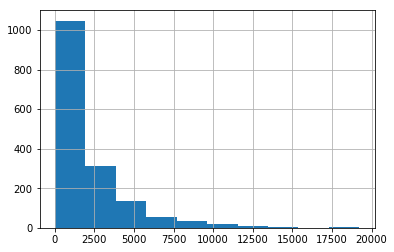

In [215]:
casual_drivers['lifetime_completed_trips'].hist()

In [217]:
len(casual_drivers.loc[ casual_drivers['lifetime_completed_trips'] < 50 ])

38

In [222]:
casual_drivers.sort_values('lifetime_completed_trips')
casual_drivers['cum_sum_canceled'] = casual_drivers.canceled.cumsum(axis=0)

In [230]:
cum_sum_canceled = casual_drivers.canceled.cumsum(axis=0)

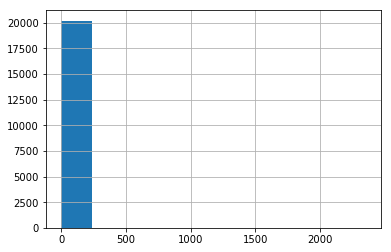

In [236]:
driver_stats.requests.hist()

In [234]:
requests_per_driver['cum_sum_cancels'] = requests_per_driver.canceled.cumsum(axis0)

AttributeError: 'DataFrame' object has no attribute 'canceled'

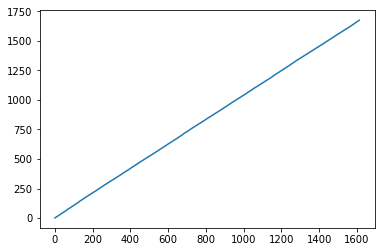

In [231]:
plt.plot(np.arange(0, len(casual_drivers)), cum_sum_canceled)

In [214]:

summary = casual_drivers.agg({
    'first_completed_trip': ['mean', 'median', 'std'],
    'lifetime_rating': ['mean','median','std'],
    'lifetime_fares': ['mean', 'median', 'std'],
    'lifetime_completed_trips': ['mean', 'median', 'std']
})

ValueError: no results

In [145]:
driver_stats.loc[ (driver_stats['requests']<11) ].agg({'canceled':'sum'})

canceled    5323.0
dtype: float64

In [196]:
(775 + 776 + 124)/5323

0.31467217734360325

In [146]:
drivers_with_high_cancel_rate = driver_stats.loc[ (driver_stats['requests']==1) & (driver_stats['canceled']==1)].index

In [147]:
drivers_with_high_cancel_rate.join(drivers, how='left')

Index(['4003-2bf4', '4016-d38f', '4023-f9cc', '402f-2c42', '4032-9b57',
       '4033-ec0d', '4037-39ca', '4038-9eee', '4045-297a', '4047-d386',
       ...
       '4fdf-53d2', '4fe3-9c43', '4fe4-234e', '4fe5-b745', '4feb-97d8',
       '4fee-3c15', '4ff0-3b5f', '4ff8-c302', '4ff9-c16d', '4ffe-51b0'],
      dtype='object', name='driver_id', length=775)

In [148]:
driver_stats.agg({'requests':['mean', 'std', 'median', 'sum']})

,requests
mean,2.962824
std,16.691400
median,2.000000
sum,59852.000000


In [149]:
driver_stats['requests'].value_counts().sort_values(ascending=[False])

1       7466
2       4363
3       2680
4       1836
5       1366
6        852
7        628
8        388
9        235
10       164
11       109
12        47
13        22
14        20
16        11
15         6
18         3
21         1
19         1
20         1
17         1
2353       1
Name: requests, dtype: int64

In [150]:
driver_stats['canceled'].value_counts().sort_values(ascending=[False])

0.0     15504
1.0      3984
2.0       601
3.0        87
4.0        19
5.0         3
6.0         1
7.0         1
80.0        1
Name: canceled, dtype: int64

In [151]:
# If a rider orders another trip within 20 minutes and it's completed successfully, let's 
# assume the rider canceled because they either weren't ready or made a mistake. 
# However, if they don't ever request another trip, this is a big deal
rider_request_mistakes = []
rider_cancel_last_trip = []
time_to_rerequest = []

# For those riders who
time_to_next_completed_trip = []
for trip in canceled_trips.itertuples():
    window_start = trip.request_time
    window_end = trip.request_time + dt.timedelta(minutes=20)
    subsequent_requests = trips.loc[   (trips['rider_id']==trip.rider_id) \
                                     & (trips['request_time']>window_start) \
                                     & (trips['request_time']<window_end) \
                                     & (trips['trip_status']=='completed') ]
    if (len(subsequent_requests)>0):
        rider_request_mistakes.append(trip.Index)
        time_to_rerequest.append( subsequent_requests.request_time - trip.request_time )

    later_requests = trips.loc[   (trips['rider_id']==trip.rider_id) \
                                & (trips['request_time']>window_end) \
                                & (trips['trip_status']=='completed') ]
    if len(later_requests)==0:
        rider_cancel_last_trip.append(trip.Index)
    else:
        later_requests.sort_values('request_time')
        time_to_next_completed_trip.append( later_requests.iloc[0]['request_time'] \
                                          - trip.request_time )
        

            

In [155]:
len(rider_request_mistakes)/len(canceled_trips)

0.007616409901332871

In [156]:
len(rider_cancel_last_trip)/len(canceled_trips)

0.9008135710576424

In [157]:
np.mean(time_to_next_completed_trip)

Timedelta('7 days 19:09:30.157068')

(array([ 23.,   7.,   2.,   1.,   1.,   5.,   3.,   0.,   0.,   2.]),
 array([  1. ,   2.6,   4.2,   5.8,   7.4,   9. ,  10.6,  12.2,  13.8,
         15.4,  17. ]),
 <a list of 10 Patch objects>)

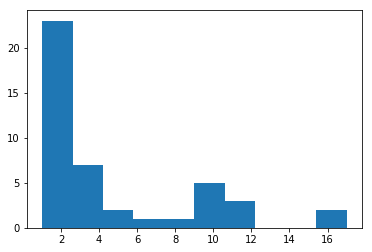

In [158]:
plt.hist( time_to_rerequest/np.timedelta64(60, 's') )

In [159]:
len(time_to_next_completed_trip)/len(canceled_trips)

0.09918642894235763

(array([ 447.,  679.,  529.,  545.,  652.,  421.,  637.,  611.,  513.,  743.]),
 array([ 734602.        ,  734604.79951389,  734607.59902778,
         734610.39854167,  734613.19805556,  734615.99756944,
         734618.79708333,  734621.59659722,  734624.39611111,
         734627.195625  ,  734629.99513889]),
 <a list of 10 Patch objects>)

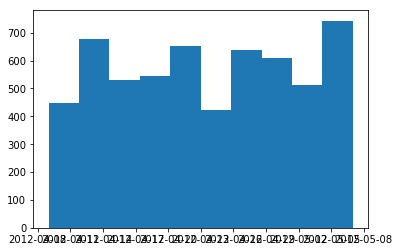

In [162]:
plt.hist(canceled_trips.request_time.values)

In [163]:
def norm_perc(x, n):
    return (np.round(100*len(x)/n,1), np.round((100*len(x)*np.sqrt(1/n)/n), 1))

In [164]:
n_canceled_trips = len(canceled_trips)
canceled_trips.groupby("start_geo").agg({
    'estimated_time_to_arrival':['mean', 'std', 'median'], 
    'surge_multiplier':['mean', 'std', 'median'], 
    'rider_payment':['mean'], 
    'rider_id':['count', lambda x: norm_perc(x, n_canceled_trips)]}).rename(columns={'<lambda>': '(total trips, uncertainty)%', 'rider_id':'All Canceled Trips'})

estimated_time_to_arrival                  surge_multiplier  \
                                   mean       std median             mean   
start_geo                                                                   
Allen Abby                     4.634712  3.191625  4.070         1.213212   
Blair Bend                     5.779977  3.797827  5.025         1.291810   
Chelsea Court                  4.394054  2.904214  3.950         1.218509   
Daisy Drive                    4.403351  2.985751  3.800         1.121220   

                               rider_payment All Canceled Trips  \
                    std median          mean              count   
start_geo                                                         
Allen Abby     0.389378    1.0      0.734606                878   
Blair Bend     0.450411    1.0      0.741776                464   
Chelsea Court  0.388007    1.0      0.642715               4025   
Daisy Drive    0.285276    1.0      0.765424                410   

                                           
              (total trips, uncertainty)%  
start_geo                                  
Allen Abby                    (15.2, 0.2)  
Blair Bend                     (8.0, 0.1)  
Chelsea Court                 (69.7, 0.9)  
Daisy Drive                    (7.1, 0.1)

In [165]:
completed_trips = trips.loc[trips['trip_status']=='completed']
n_completed_trips = len(completed_trips)
completed_trips.groupby('start_geo').agg({
    'estimated_time_to_arrival':['mean', 'std'], 
    'surge_multiplier':['mean', 'std', 'median'], 
    'rider_payment':['mean'], 
    'rider_id':['count', lambda x: norm_perc(x, n_completed_trips)]}).rename(columns={'<lambda>': '(total trips, uncertainty)%', 'rider_id':'All Completed Trips'})

estimated_time_to_arrival           surge_multiplier            \
                                   mean       std             mean       std   
start_geo                                                                      
Allen Abby                     3.138944  1.989670         1.162667  0.362004   
Blair Bend                     4.243841  2.481447         1.200051  0.361876   
Chelsea Court                  3.010950  1.877043         1.151115  0.323969   
Daisy Drive                    3.176581  1.990283         1.104548  0.250857   

                     rider_payment All Completed Trips  \
              median          mean               count   
start_geo                                                
Allen Abby       1.0      8.496398                9600   
Blair Bend       1.0      9.875035                3899   
Chelsea Court    1.0      7.963135               36285   
Daisy Drive      1.0      9.072206                4354   

                                           
              (total trips, uncertainty)%  
start_geo                                  
Allen Abby                    (17.7, 0.1)  
Blair Bend                     (7.2, 0.0)  
Chelsea Court                 (67.0, 0.3)  
Daisy Drive                    (8.0, 0.0)

In [166]:
completed_trips_rush = completed_trips.loc[completed_trips['is_rush_hour']==True]
canceled_trips_rush = canceled_trips.loc[canceled_trips['is_rush_hour']==True]
n_completed_trips_rush = len(completed_trips_rush)
n_canceled_trips_rush = len(canceled_trips_rush)

In [167]:
canceled_trips_rush.groupby("start_geo").agg({
    'estimated_time_to_arrival':['mean', 'std', 'median'], 
    'surge_multiplier':['mean', 'std', 'median'], 
    'rider_payment':['mean'], 
    'rider_id':['count', lambda x: norm_perc(x, n_canceled_trips_rush)]}).rename(columns={'<lambda>': '(total trips, uncertainty)%', 'rider_id':'Canceled Rush-hour Trips'})

estimated_time_to_arrival                  surge_multiplier  \
                                   mean       std median             mean   
start_geo                                                                   
Allen Abby                     5.601223  3.337200  5.750         1.317361   
Blair Bend                     5.772400  3.803349  4.920         1.279221   
Chelsea Court                  5.455651  3.251195  4.985         1.331622   
Daisy Drive                    5.002623  3.349031  4.600         1.164062   

                               rider_payment Canceled Rush-hour Trips  \
                    std median          mean                    count   
start_geo                                                               
Allen Abby     0.494208    1.0      0.742778                      144   
Blair Bend     0.406958    1.0      0.833247                       77   
Chelsea Court  0.495965    1.0      0.594884                      740   
Daisy Drive    0.293510    1.0      0.771875                       64   

                                           
              (total trips, uncertainty)%  
start_geo                                  
Allen Abby                    (14.0, 0.4)  
Blair Bend                     (7.5, 0.2)  
Chelsea Court                 (72.2, 2.3)  
Daisy Drive                    (6.2, 0.2)

In [168]:
completed_trips_rush.groupby('start_geo').agg({
    'estimated_time_to_arrival':['mean', 'std', 'median'], 
    'surge_multiplier':['mean', 'std', 'median'], 
    'rider_payment':['mean'],
    'rider_id':['count', lambda x: norm_perc(x, n_completed_trips_rush)]
}).rename(columns={'<lambda>': '(total trips, uncertainty)%', 'rider_id':'Completed Rush-hour Trips'})

estimated_time_to_arrival                  surge_multiplier  \
                                   mean       std median             mean   
start_geo                                                                   
Allen Abby                     3.260177  2.152226   2.78         1.202462   
Blair Bend                     4.346024  2.353540   3.98         1.205840   
Chelsea Court                  3.206276  1.970227   2.85         1.196185   
Daisy Drive                    3.350931  2.126349   2.93         1.188098   

                               rider_payment Completed Rush-hour Trips  \
                    std median          mean                     count   
start_geo                                                                
Allen Abby     0.487944    1.0      8.888005                      1665   
Blair Bend     0.324655    1.0      9.829322                       702   
Chelsea Court  0.379964    1.0      8.054827                      5583   
Daisy Drive    0.321772    1.0      9.632693                       773   

                                           
              (total trips, uncertainty)%  
start_geo                                  
Allen Abby                    (19.1, 0.2)  
Blair Bend                     (8.0, 0.1)  
Chelsea Court                 (64.0, 0.7)  
Daisy Drive                    (8.9, 0.1)

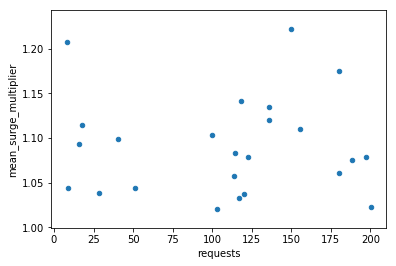

In [169]:
weekday_by_hour.plot(x='requests', y='mean_surge_multiplier', kind='scatter')

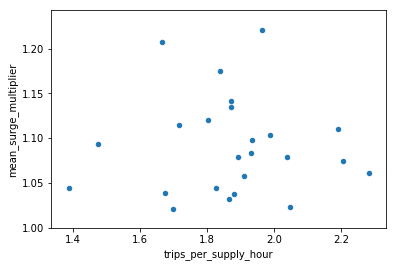

In [170]:
weekday_by_hour.plot( y='mean_surge_multiplier', x='trips_per_supply_hour', kind='scatter')

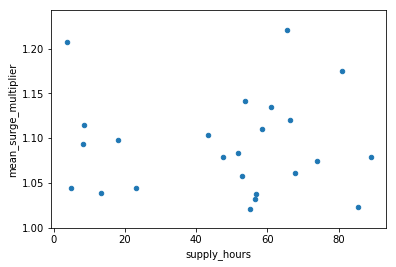

In [171]:
weekday_by_hour.plot( y='mean_surge_multiplier', x='supply_hours', kind='scatter')

In [172]:
trips.trip_status.value_counts()

completed         54138
rider_canceled     5777
failed               49
unfulfilled          34
Name: trip_status, dtype: int64

In [173]:
trips_by_hour_means = trips.groupby(['date', 'hour']).mean()
trips_by_hour_counts = trips.groupby(['date', 'hour']).count()
trips_by_hour_status = trips.groupby(['date', 'hour', 'trip_status']).count()

In [174]:
trips_by_hour_counts.sum()

rider_id                     59998
estimated_time_to_arrival    57498
trip_price_pre_discount      59998
rider_payment                59998
driver_id                    59852
actual_time_to_arrival       53582
driver payout                59852
trip_status                  59998
request_time                 59998
surge_multiplier             59998
start_geo                    59998
end_geo                      59998
dow                          59998
is_rush_hour                 59998
completed                    59998
canceled                     59998
dtype: int64

In [184]:
trips_by_hour = trips.groupby(['hour']).agg({
    'rider_id':'count', 
    'estimated_time_to_arrival':'mean',
    'actual_time_to_arrival':'mean',
    'trip_price_pre_discount':'mean', 
    'completed':'sum', 'canceled':'sum'
})

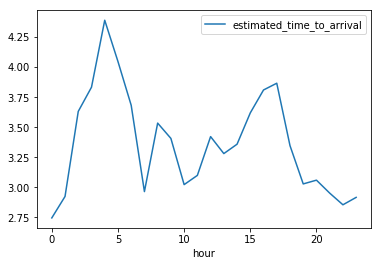

In [186]:
trips_by_hour.plot(y='estimated_time_to_arrival')

In [195]:
weekday_trips_by_hour = trips.loc[trips['dow'].isin(weekdays)].groupby('hour', 'start_geo').mean()['estimated_time_to_arrival'].unstack().plot()

ValueError: No axis named start_geo for object type <class 'pandas.core.frame.DataFrame'>

In [ ]:
unfulfilled = trips.loc[ trips['trip_status'] == "unfulfilled" ]

In [ ]:
start_geo_counts = trips['start_geo'].value_counts()/len(trips)
start_geo_counts

In [ ]:
unfulfilled['start_geo'].value_counts()/len(unfulfilled)

In [ ]:
E